In [8]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
from plotly.subplots import make_subplots
import pandas as pd
import polars as pl
import polars.selectors as cs
from datetime import date

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import seaborn as sns

%matplotlib inline

Just for Alex: /home/adb/Documents/DTU/3rdTerm/MLES_Course

In [9]:
Bornholm_Network_Manager = r"/home/adb/Documents/DTU/3rdTerm/MLES_Course/Bornholm Network Manager 23-09-2024 21-05-29.csv"
DMI_dataset = r"/home/adb/Documents/DTU/3rdTerm/MLES_Course/DMI Bornholm 24-09-2024 01-07-21.csv"
Energinet_dataset = r"/home/adb/Documents/DTU/3rdTerm/MLES_Course/Energiner Balancing Prices 24-09-2024 01-09-47.csv"
Forcast_norwegian_dataset = r"/home/adb/Documents/DTU/3rdTerm/MLES_Course/Norwegian Forecast dataset.csv"

In [10]:
def plot_ts(data: pl.DataFrame, data_secondary_y: pl.DataFrame = None, vlines=None, selection=False):
	fig = FigureWidgetResampler(make_subplots(specs=[[{"secondary_y": True}]]))

	traces = []
	for c in data.columns:
		if c == "time":
			continue
		fig.add_trace(go.Scattergl(name=c, showlegend=True), hf_x=data["time"].to_pandas(), hf_y=data[c].to_pandas())
		traces.append(c)
	
	if data_secondary_y is not None:
		for c in data_secondary_y.columns:
			if c == "time":
				continue
			fig.add_trace(go.Scattergl(name=c, showlegend=True), hf_x=data_secondary_y["time"].to_pandas(), hf_y=data_secondary_y[c].to_pandas(), secondary_y=True)
			traces.append(c)

	if vlines is not None:
		for v in vlines:
			fig.add_vline(v, line_width=1, line_dash="dash")

	if selection:
		labels = [t for t in traces if "_" not in t]
		buttons = [{"label": "All", "method": "update", "args": [{"visible": [True for t in traces]}, {"title": "All"}]}]
		for l in labels:
			b = {}
			b["label"] = l
			b["method"] = "update"
			b["args"] = [
				{"visible" :[l in t for t in traces]},
				{"title": l},
			]
			buttons.append(b)
		fig.update_layout(
			updatemenus=[
				dict(
					active=0,
					buttons=buttons,
				)
			])
	return fig

In [11]:
time_cl = pl.col('time')
kalby_active_power = pl.col('804120')
#weather data
max_temp = pl.col('406464')
mean_temp = pl.col('406432')
min_temp = pl.col('406480')
accum_precip = pl.col('406656')
mean_wind_speed = pl.col('406640')
mean_wind_dirn = pl.col('406496')
mean_humidity = pl.col('406448')
#forecast data
fr_wind_dirn = pl.col('128270')
fr_accum_precip = pl.col('128238')
fr_mean_humidity = pl.col('128254')
fr_wind_speed = pl.col('128286')
fr_mean_temp = pl.col('128190')
#create column mappings
prev_day_power = pl.col('prev_day_power')

weekly_5th_quantile = pl.col("5thQuantile")
weekly_50th_quantile = pl.col("50thQuantile")
weekly_90th_quantile = pl.col("90thQuantile")

hourly_5th_quantile = pl.col("Hour_5thQuantile")
hourly_50th_quantile = pl.col("Hour_50thQuantile")
hourly_90th_quantile = pl.col("Hour_90thQuantile")

In [12]:
wind_data = pl.read_csv(Bornholm_Network_Manager , separator= ',')

wind_data = wind_data.with_columns(
    pl.col('ts').str.to_datetime("%Y-%m-%d %H:%M:%S").alias('ts')
)
wind_data = wind_data.sort(pl.col('ts'))

simplified_columns = {}
new_col_wind = {} 
for c in wind_data.columns:
	new_name = c.split("|")[-1].strip()
	simplified_columns[new_name] = c
	new_col_wind[c] = new_name
 
wind_data = wind_data.rename(new_col_wind)
wind_data = wind_data.with_columns(
    pl.col("ts").dt.truncate("1h").alias("time")
)
wind_data = wind_data.group_by('time').agg(pl.all().mean())

#wind_data = wind_data.collect()

In [13]:
dmi = pl.read_csv(DMI_dataset, separator= ',', ignore_errors= True)
dmi = dmi.select(
    pl.col('ts').str.to_datetime("%Y-%m-%d %H:%M:%S"),
    pl.exclude('ts')
)
dmi = dmi.sort(pl.col('ts'))

simplified_columns = {}
new_col_dmi = {} 
for c in dmi.columns:
	new_name = c.split("|")[-1].strip()
	simplified_columns[new_name] = c
	new_col_dmi[c] = new_name

dmi = dmi.rename(new_col_dmi)
dmi = dmi.with_columns(
    pl.col("ts").dt.truncate("1h").alias("time")
)
dmi = dmi.group_by('time').agg(pl.all().mean())

energinet = pl.read_csv(Energinet_dataset , separator= ',', ignore_errors= True)

simplified_columns = {}
new_col_energinet = {} 
for c in energinet.columns:
	new_name = c.split("|")[-1].strip()
	simplified_columns[new_name] = c
	new_col_energinet[c] = new_name

energinet = energinet.rename(new_col_energinet)
energinet = energinet.select(
    pl.col('ts').str.to_datetime("%Y-%m-%d %H:%M:%S"),
    pl.col('804694').str.to_datetime("%Y-%m-%d %H:%M:%S"),
    pl.col('804695').str.to_datetime("%Y-%m-%d %H:%M:%S"),
    pl.col('804696'),
    pl.exclude('ts', '804696', '804694', '804695').str.replace(",", ".").cast(pl.Float64, strict=False)
)
energinet = energinet.filter(pl.col('804696') == 'DK2')
energinet = energinet.rename({'ts':'time'})
energinet = energinet.with_columns(
    pl.col("time").dt.truncate("1h").alias("time")
)
energinet = energinet.group_by('time').agg(pl.all().mean())

In [14]:
forecast = pl.read_csv(Forcast_norwegian_dataset , separator= ',', ignore_errors= True)

forecast = forecast.select(
    pl.col('ts').str.to_datetime("%Y-%m-%d %H:%M:%S"),
    pl.exclude('ts')
)
simplified_columns = {}
new_col_forecast = {} 
for c in forecast.columns:
	new_name = c.split("|")[-1].strip()
	simplified_columns[new_name] = c
	new_col_forecast[c] = new_name

forecast = forecast.rename(new_col_forecast)

forecast = forecast.rename({'ts':'time'})
forecast = forecast.with_columns(
    pl.col("time").dt.truncate("1h").alias("time")
)
forecast = forecast.group_by('time').agg(pl.all().mean())

In [15]:
# merge all datasets into one
temp1 = wind_data.join(dmi, on = 'time', how = 'left', validate= 'm:1')
cumulative_dataset = temp1.join(forecast, on = 'time', how = 'left', validate= 'm:1')
#cumulative_dataset = temp2.join(energinet, on='time', how = 'left', validate = 'm:1')
cumulative_dataset = cumulative_dataset.drop('ts', 'ts_right')
cumulative_dataset = cumulative_dataset.drop_nulls(subset = ['804120'])
cumulative_dataset = cumulative_dataset.with_columns(kalby_active_power.shift(24).alias('prev_day_power'))
# cumulative_dataset = cumulative_dataset.drop_nulls(subset = ['prev_day_power'])

In [16]:
#quantile of the week ahead of that data point
cumulative_dataset = cumulative_dataset.sort("time")
df = cumulative_dataset.rolling(index_column= 'time', period='1w').agg([
        pl.quantile("804120", 0.05).alias("5thQuantile"),
        pl.quantile("804120", 0.50).alias("50thQuantile"),
        pl.quantile("804120", 0.95).alias("90thQuantile"),
])
cumulative_dataset = cumulative_dataset.join(df, on="time", how="left")

In [17]:
#quantile of the hour of the day for the previous week
cumulative_dataset = cumulative_dataset.with_columns(pl.col("time").dt.hour().alias("hour_of_day"))
cumulative_dataset = cumulative_dataset.with_columns([
    pl.lit(None).cast(pl.Float64).alias("Hour_5thQuantile"),
    pl.lit(None).cast(pl.Float64).alias("Hour_50thQuantile"),
    pl.lit(None).cast(pl.Float64).alias("Hour_90thQuantile"),
])
rolling_quantile_hourly = pl.DataFrame()
for hour in range(24):  
    hour_df = cumulative_dataset.filter(pl.col("time").dt.hour() == hour)
    rolling_quantiles = (hour_df.rolling(index_column="time", period="1w").agg([
            pl.quantile("804120", 0.05).alias("Hour_5thQuantile"),
            pl.quantile("804120", 0.50).alias("Hour_50thQuantile"),
            pl.quantile("804120", 0.95).alias("Hour_90thQuantile"),
        ]))
    rolling_quantile_hourly = pl.concat([rolling_quantile_hourly, rolling_quantiles], how="vertical")
rolling_quantile_hourly = rolling_quantile_hourly.sort("time")

for quantile_col in ["Hour_5thQuantile", "Hour_50thQuantile", "Hour_90thQuantile"]:
    cumulative_dataset = cumulative_dataset.with_columns(
        pl.when(cumulative_dataset["time"].is_in(rolling_quantile_hourly["time"]))
          .then(rolling_quantile_hourly[quantile_col])
          .otherwise(pl.col(quantile_col)).alias(quantile_col)
    )

In [18]:
plot_ts(cumulative_dataset.select(time_cl, kalby_active_power, pl.col('5thQuantile'), pl.col('50thQuantile'), pl.col('90thQuantile')))

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> 804120 <i style="color:#fc9944">~2h</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '1fdb3ee5-2612-49af-a27a-2ffc11ae291a',
              'x': array([datetime.datetime(2023, 9, 23, 0, 0),
                          datetime.datetime(2023, 9, 23, 2, 0),
                          datetime.datetime(2023, 9, 23, 4, 0), ...,
                          datetime.datetime(2023, 12, 31, 18, 0),
                          datetime.datetime(2023, 12, 31, 21, 0),
                          datetime.datetime(2023, 12, 31, 23, 0)], dtype=object),
              'y': array([  -63.81669922,    27.69895241,   -24.62017144, ..., -4054.75022134,
                          -3631.57572811, -2064.36792093])},
             {'name': '<b style="color:sandybrown">[R]</b> 5thQuantile <i style="color:#fc9944">~2h</i>',
              'showlegend': True,
              'type': 'scattergl',
   

In [19]:
plot_ts(cumulative_dataset.select(time_cl, kalby_active_power, pl.col('5thQuantile'), pl.col('50thQuantile'), pl.col('90thQuantile')))

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> 804120 <i style="color:#fc9944">~2h</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '2abc497c-13ce-4fc9-b43d-16741102f057',
              'x': array([datetime.datetime(2023, 9, 23, 0, 0),
                          datetime.datetime(2023, 9, 23, 2, 0),
                          datetime.datetime(2023, 9, 23, 4, 0), ...,
                          datetime.datetime(2023, 12, 31, 18, 0),
                          datetime.datetime(2023, 12, 31, 21, 0),
                          datetime.datetime(2023, 12, 31, 23, 0)], dtype=object),
              'y': array([  -63.81669922,    27.69895241,   -24.62017144, ..., -4054.75022134,
                          -3631.57572811, -2064.36792093])},
             {'name': '<b style="color:sandybrown">[R]</b> 5thQuantile <i style="color:#fc9944">~2h</i>',
              'showlegend': True,
              'type': 'scattergl',
   

In [20]:
plot_ts(cumulative_dataset.select(time_cl, kalby_active_power, pl.col('Hour_5thQuantile'), pl.col('Hour_50thQuantile'), pl.col('Hour_90thQuantile'), pl.col('hour_of_day')).filter(pl.col('hour_of_day') == 0))

FigureWidgetResampler({
    'data': [{'name': '804120',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '88200420-bbdc-4006-a7f1-5e4a0614977b',
              'x': array([datetime.datetime(2023, 9, 23, 0, 0),
                          datetime.datetime(2023, 9, 24, 0, 0),
                          datetime.datetime(2023, 9, 25, 0, 0),
                          datetime.datetime(2023, 9, 26, 0, 0),
                          datetime.datetime(2023, 9, 27, 0, 0),
                          datetime.datetime(2023, 9, 28, 0, 0),
                          datetime.datetime(2023, 9, 29, 0, 0),
                          datetime.datetime(2023, 9, 30, 0, 0),
                          datetime.datetime(2023, 10, 1, 0, 0),
                          datetime.datetime(2023, 10, 2, 0, 0),
                          datetime.datetime(2023, 10, 3, 0, 0),
                          datetime.datetime(2023, 10, 4, 0, 0),
                          datetime.datetime(20

Without correlation

In [ ]:
features_selected = [kalby_active_power, prev_day_power, weekly_50th_quantile, weekly_5th_quantile, weekly_90th_quantile,
                     hourly_5th_quantile, hourly_50th_quantile, hourly_90th_quantile,
                     max_temp, mean_temp, min_temp, accum_precip, mean_wind_speed, mean_wind_dirn, mean_humidity,
                     fr_wind_dirn, fr_accum_precip, fr_mean_humidity, fr_wind_speed, fr_mean_temp]

# Remove rows with null or NaN values from the selected columns
cumulative_dataset = cumulative_dataset.select(features_selected).drop_nulls()

Feature correlation matrix

In [22]:
cumulative_dataset_p = cumulative_dataset.to_pandas()

In [27]:
correlation = cumulative_dataset_p.corr()['804120'].drop('804120')

/tmp/ipykernel_41784/1725410884.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




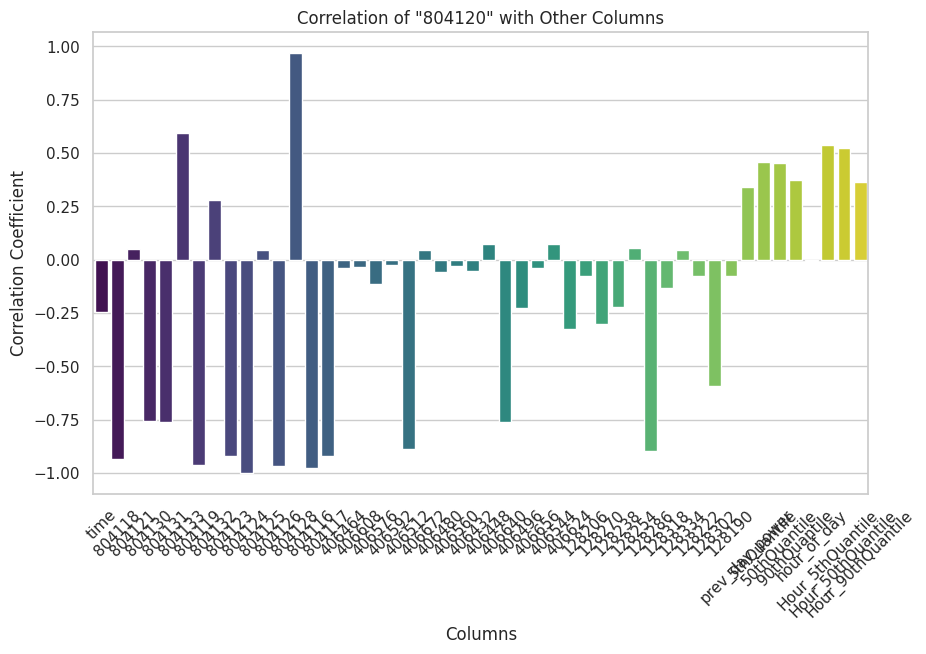

In [25]:
sns.set(style='whitegrid')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index, y=correlation.values, palette='viridis')
plt.title('Correlation of "804120" with Other Columns')
plt.xlabel('Columns')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_41784/3574855762.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




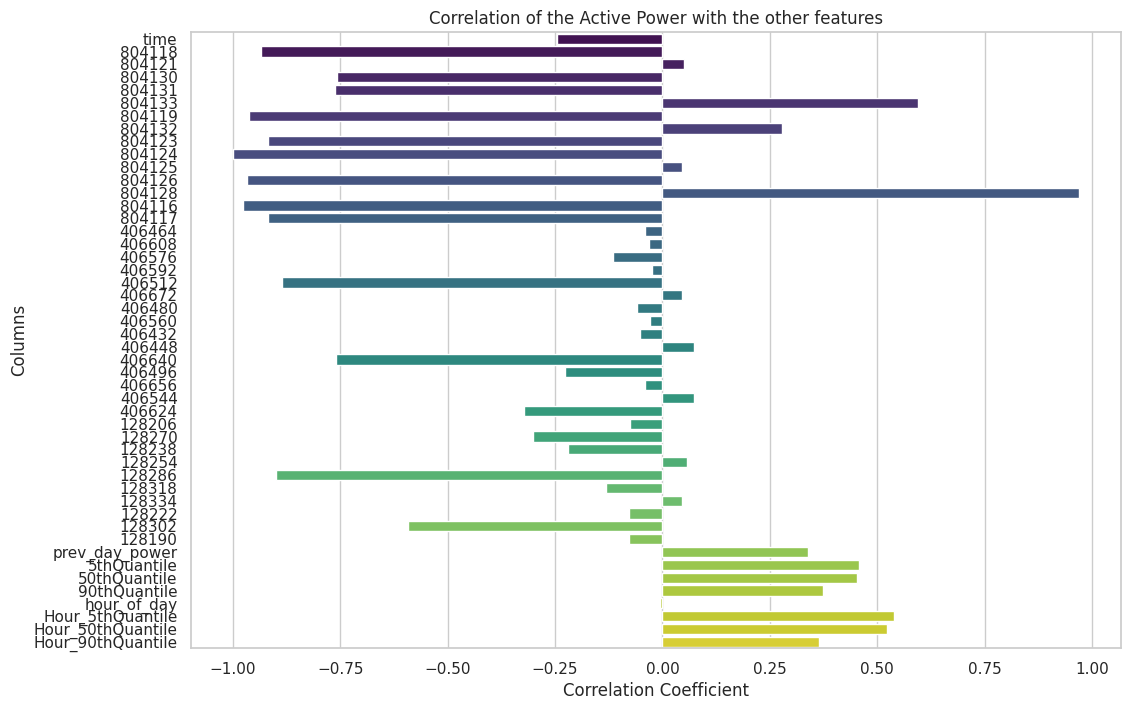

In [29]:
correlation = cumulative_dataset_p.corr()['804120'].drop('804120')

# Set the style of seaborn
sns.set(style='whitegrid')

# Create a horizontal bar plot
plt.figure(figsize=(12, 8))  # Increase figure size
sns.barplot(y=correlation.index, x=correlation.values, palette='viridis')  # Horizontal bar plot
plt.title('Correlation of the Active Power with the other features')
plt.ylabel('Columns')
plt.xlabel('Correlation Coefficient')
plt.show()

time                -0.245564
804118              -0.934624
804130              -0.757304
804131              -0.763279
804133               0.595790
804119              -0.963306
804132               0.279446
804123              -0.918413
804124              -0.999757
804126              -0.968259
804128               0.969059
804116              -0.977717
804117              -0.918484
406576              -0.115259
406512              -0.887063
406640              -0.760967
406496              -0.227719
406624              -0.323135
128270              -0.301253
128238              -0.219886
128286              -0.899318
128318              -0.131710
128302              -0.592518
prev_day_power       0.339012
5thQuantile          0.456969
50thQuantile         0.452109
90thQuantile         0.374718
Hour_5thQuantile     0.538526
Hour_50thQuantile    0.523079
Hour_90thQuantile    0.365490
Name: 804120, dtype: float64


/tmp/ipykernel_41784/3145517702.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




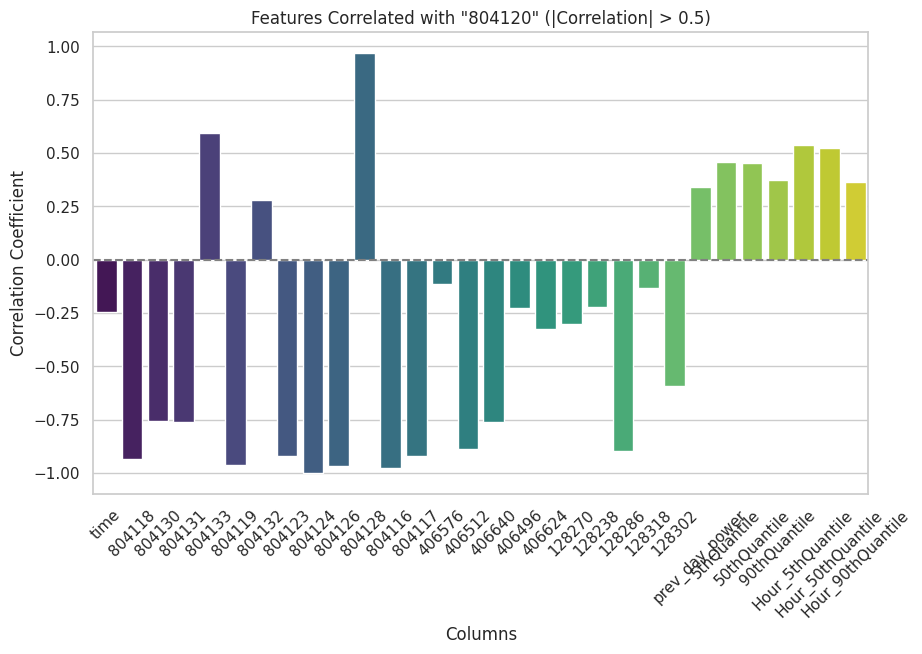

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming cumulative_dataset_p is already defined

# Step 1: Calculate the correlation
correlation = cumulative_dataset_p.corr()['804120'].drop('804120')

# Step 2: Filter features with correlation > 0.5 or < -0.5
filtered_correlation = correlation[(correlation > 0.10) | (correlation < -0.10)]

# Display the filtered correlations
print(filtered_correlation)

# Step 3: Create a bar plot for filtered correlations
sns.set(style='whitegrid')

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=filtered_correlation.index, y=filtered_correlation.values, palette='viridis')
plt.title('Features Correlated with "804120" (|Correlation| > 0.5)')
plt.xlabel('Columns')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--')  # Reference line at y=0
plt.show()


In [32]:
filtered_correlation

time                -0.245564
804118              -0.934624
804130              -0.757304
804131              -0.763279
804133               0.595790
804119              -0.963306
804132               0.279446
804123              -0.918413
804124              -0.999757
804126              -0.968259
804128               0.969059
804116              -0.977717
804117              -0.918484
406576              -0.115259
406512              -0.887063
406640              -0.760967
406496              -0.227719
406624              -0.323135
128270              -0.301253
128238              -0.219886
128286              -0.899318
128318              -0.131710
128302              -0.592518
prev_day_power       0.339012
5thQuantile          0.456969
50thQuantile         0.452109
90thQuantile         0.374718
Hour_5thQuantile     0.538526
Hour_50thQuantile    0.523079
Hour_90thQuantile    0.365490
Name: 804120, dtype: float64

In [34]:

correlated_columns = filtered_correlation.index.tolist()

# Remove '804120' and 'time' from the list
correlated_columns = [col for col in correlated_columns if col not in ['804120', 'time']]

# Display the resulting list
print(correlated_columns)
print(len(correlated_columns))

['804118', '804130', '804131', '804133', '804119', '804132', '804123', '804124', '804126', '804128', '804116', '804117', '406576', '406512', '406640', '406496', '406624', '128270', '128238', '128286', '128318', '128302', 'prev_day_power', '5thQuantile', '50thQuantile', '90thQuantile', 'Hour_5thQuantile', 'Hour_50thQuantile', 'Hour_90thQuantile']
29


28 features are over 10% of correlation

Step 3 Alex

## Gradient Descendent 

## Step 2.2

In [35]:
#preprocessing 
features_selected.remove(kalby_active_power)

X_0 = cumulative_dataset.select(features_selected)

Y_0 = cumulative_dataset.select([kalby_active_power])

NameError: name 'features_selected' is not defined

In [ ]:
scaler = MinMaxScaler()

# Fit and transform the selected columns
X_normalized = scaler.fit_transform(X_0)
X_normalized = pd.DataFrame(X_normalized, columns=X_0.columns)

# y_max = max(Y_0)
# y_min = min(Y_0)
# y_normalized = (Y_0 - y_min) / (y_max - y_min)
Y_normalized = scaler.fit_transform(Y_0)
Y_normalized = pd.DataFrame(Y_normalized, columns=Y_0.columns)

lr = LinearRegression()

# Define the cross-validation method
kf = KFold(n_splits=10, shuffle=True, random_state=42)


In [ ]:
# Create scoring functions for RMSE and MAE
scoring_rmse = make_scorer(mean_squared_error, squared=False)  # RMSE
scoring_mae = make_scorer(mean_absolute_error)  # MAE

# Perform cross-validation for RMSE
rmse_scores = cross_val_score(lr, X_normalized, Y_normalized, cv=kf, scoring=scoring_rmse)

# Perform cross-validation for MAE
mae_scores = cross_val_score(lr, X_normalized, Y_normalized, cv=kf, scoring=scoring_mae)

# Calculate mean and standard deviation for RMSE and MAE
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

# Print the mean and standard deviation of RMSE and MAE
print(f"Mean Test RMSE: {mean_rmse:.5f} ± {std_rmse:.5f}")
print(f"Mean Test MAE: {mean_mae:.5f} ± {std_mae:.5f}")

In [36]:

# Plot the RMSE and MAE for each fold
plt.figure(figsize=(12, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), rmse_scores, marker='o', linestyle='-', color='b')
plt.title('10-Fold Cross-Validation RMSE for Linear Regression')
plt.xlabel('Fold Number')
plt.ylabel('Root Mean Squared Error')
plt.xticks(range(1, 11))
plt.grid()
plt.axhline(mean_rmse, color='r', linestyle='--', label=f'Mean RMSE: {mean_rmse:.5f}')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), mae_scores, marker='o', linestyle='-', color='g')
plt.title('10-Fold Cross-Validation MAE for Linear Regression')
plt.xlabel('Fold Number')
plt.ylabel('Mean Absolute Error')
plt.xticks(range(1, 11))
plt.grid()
plt.axhline(mean_mae, color='r', linestyle='--', label=f'Mean MAE: {mean_mae:.5f}')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'rmse_scores' is not defined

In [ ]:
Y_0 = Y_0.to_pandas()
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Y_0, test_size=0.4, shuffle=False)

# Train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on training and testing sets
y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE w/ custom linear regression: {mse:0.5f}")


In [ ]:
plt.figure(figsize=(14, 7))

# Plot actual values
plt.scatter(y_test.index, y_test, color='orange', alpha=0.8, label='Actual Values', s=50)
# Plot predictions
plt.scatter(y_test.index, y_pred, color='blue', alpha=0.8, label='Predicted Values', s=50)

# Plot the ideal fit line
plt.plot(y_test.index, y_test, color='red', linestyle='--', label='Ideal Fit', linewidth=1)

# Enhancing the plot
plt.title('Testing Results: Actual vs Predicted Values', fontsize=16)
plt.xlabel('Index', fontsize=14)  
plt.ylabel('Values', fontsize=14)  
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()